# Accelerating the Mandelbrot fractal - Numba

Below, we demonstrate how the Mandelbrot fractal set can be computed in Python. After that, we accelerate this process using the Numba package.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Parameter values and settings

In [2]:
size = 400
iterations = 100
a=-2

### The Mandelbrot fractal set computed in standard Python

In [3]:
def mandelbrot_python(size, iterations):
    m = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            c = (a + 3. / size * j + 1j * (1.5 - 3. / size * i))
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
    return m

In [4]:
Standard = %timeit -o -r1 mandelbrot_python(size, iterations)

5.99 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Now, the fractal is plotted

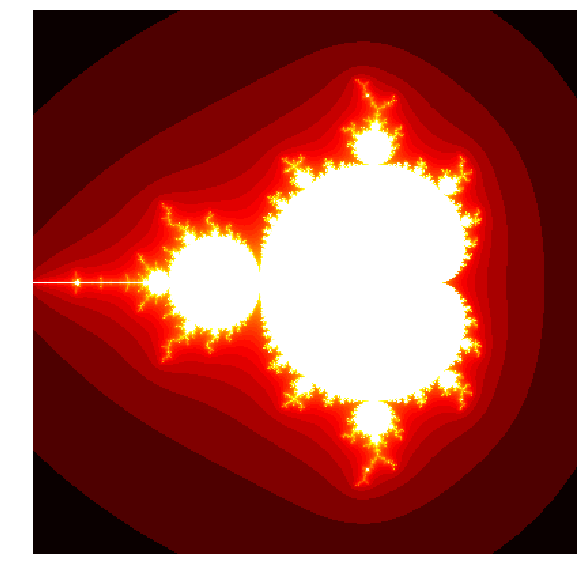

In [5]:
m=mandelbrot_python(size, iterations)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.log(m), cmap=plt.cm.hot)
ax.set_axis_off()

### The Mandelbrot fractal, computer with Numba

In [6]:
import numba
from numba import jit, complex128

In [7]:
@jit
def mandelbrot_numba(size, iterations):
    m = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            c = (a + 3. / size * j + 1j * (1.5 - 3. / size * i))
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
    return m

In [8]:
NumbaRes = %timeit -o -r1 mandelbrot_numba(size, iterations)

24.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
print('Acceleration using numba compared to looped version: %1.0f times.' % (Standard.best/NumbaRes.best))

Acceleration using numba compared to looped version: 247 times.


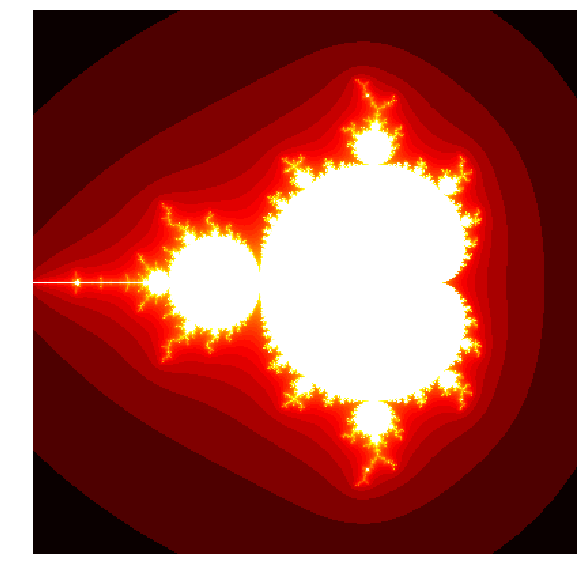

In [10]:
m=mandelbrot_numba(size, iterations)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.log(m), cmap=plt.cm.hot)
ax.set_axis_off();

## A dishonest comparison: what about a numpy matrix computation?

In [11]:
def mandelbrot_matrix(size, iterations):
    m = size
    n = size
 
    x = np.linspace(-2, 1, num=m).reshape((1, m))
    y = np.linspace(-1.5, 1.5, num=n).reshape((n, 1))
    C = np.tile(x, (n, 1)) + 1j * np.tile(y, (1, m))
 
    Z = np.zeros((n, m), dtype=complex)
    R = np.zeros((n, m))
    M = np.full((n, m), True, dtype=bool)
    for i in range(iterations):
        Z[M] = Z[M] * Z[M] + C[M]
        M[np.abs(Z) >= 10] = False
        R[np.abs(Z) >= 10] = i
        Z[np.abs(Z) >= 10] = 0  
        
    R[R==0 ] = 0.1# iterations        
        
    return R    

In [12]:
Numpy = %timeit -o mandelbrot_matrix(size, iterations)

420 ms ± 20 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


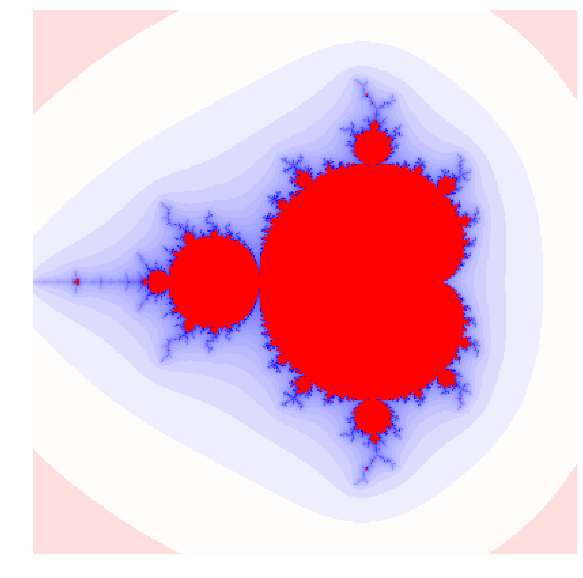

In [13]:
m=mandelbrot_matrix(size, iterations)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(1-np.log(m), cmap='bwr')
ax.set_axis_off()

In [14]:
print('Acceleration using numpy arrays: %1.0f times.' % (Numpy.best/NumbaRes.best))

Acceleration using numpy arrays: 16 times.


## Compiled but not in parallel yet
Using Numba, you can also use multiple cores at the same time to compute your calculation. This is called Parallel computing.

In [15]:
from numba import njit, prange

@njit(parallel=True)
def mandelbrot_numba_par(size, iterations):
    m = np.zeros((size, size))
    for i in prange(size):
        for j in prange(size):
            c = (a + 3. / size * j + 1j * (1.5 - 3. / size * i))
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
    return m

In [16]:
Numba_par = %timeit -o mandelbrot_numba_par(size, iterations)
print('Acceleration - numba parallel vs looped: %1.0f times.' % (Standard.best/Numba_par.best))
print('Acceleration - numba parallel vs matrix: %1.0f times.' % (Numpy.best/Numba_par.best))

8.34 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Acceleration - numba parallel vs looped: 762 times.
Acceleration - numba parallel vs matrix: 50 times.


Cleverly copied from https://ipython-books.github.io/52-accelerating-pure-python-code-with-numba-and-just-in-time-compilation/